In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import seaborn as sns
import seaborn as sns
from scipy.stats import norm, chi2,gumbel_r
import scipy.optimize as sco
import datetime

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb

In [3]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]

In [4]:
#tickers=stocks['Ticker'].to_list()

In [6]:
#tickers=get_market_cap()['Ticker'].iloc[:50].to_list()

In [7]:
tickers=df.index.to_list()

In [8]:
data=get_price(tickers,"01 Jan 2023")
data=data.dropna(axis=1)
n=len(data.columns)

In [9]:
returns=np.log(1+data.pct_change())

# General Functions

In [10]:
def halton_sequences(number,base=2):
    
    #Generate Halton sequences
    
    inv_base=1/base
    
    i=number
    halton=0
    
    while i>0:
        
        digit = i%base
        halton=halton + digit*inv_base
        i=(i-digit)/base
        inv_base=inv_base/base
        
    return halton

def generate_halton(iterations,dimensions=1,base=2):
    
    #Generate a Halton Sequences at basis k , then shuffles it
    
    rng = np.random.default_rng()
    matrix=[]
    haltons=[]
    
    for i in range(iterations):
        halton=halton_sequences(i,base=base)
        haltons.append(halton)
    
    for dim in range(dimensions):
        
        matrix.append(haltons)
    
    matrix = rng.permuted(matrix, axis=1)
    return matrix

def near_psd(x, epsilon=0):
    
    #Calculate the nearest positive semi definite matrix

    if min(np.linalg.eigvals(x))> epsilon:
        return x

    n = x.shape[0]
    var_list = np.array(np.sqrt(np.diag(x)))
    y = np.array([[x[i, j]/(var_list[i]*var_list[j]) for i in range(n)] for j in range(n)])

    eigval, eigvec = np.linalg.eig(y)
    val = np.matrix(np.maximum(eigval, epsilon))
    vec = np.matrix(eigvec)
    T = 1/(np.multiply(vec, vec) * val.T)
    T = np.matrix(np.sqrt(np.diag(np.array(T).reshape((n)) )))
    B = T * vec * np.diag(np.array(np.sqrt(val)).reshape((n)))
    near_corr = B*B.T    

    near_cov = np.array([[near_corr[i, j]*(var_list[i]*var_list[j]) for i in range(n)] for j in range(n)])
    return near_cov

In [11]:

def performance(perf,weights):
    
    #Calculate the performance of a portfolio on a daily basis
    
    return np.dot(perf,weights)


In [12]:
def rolling_var(returns,weights,window=30,Q=1):

    #This function will return the rolling VaR on a x-days window following historical,parametric and multivariate model

    value_at_risk=pd.DataFrame()

    mean=returns.rolling(window).mean().dropna()
    cov=returns.rolling(window).cov().dropna()
    corr=returns.rolling(window).corr().dropna()
    std=returns.rolling(window).std().dropna()

    index=sorted(tuple(set(cov.index.get_level_values(0))))


    var={}

    for date in index:
            
            multivariate_var=performance(np.random.multivariate_normal(mean.loc[date],cov.loc[date],10000),weights) 
            var[date]=np.percentile(multivariate_var,Q)


    var=pd.DataFrame(var.values(),index=var.keys())

    portfolio=Portfolio(returns).portfolio(weights)

    value_at_risk['Historical']=portfolio.rolling(window=window).apply(lambda x:np.percentile(x,Q))
    value_at_risk['Parametric']=portfolio.rolling(window=window).std()*norm(loc =0 , scale = 1).ppf(Q/100)
    value_at_risk['Multivariate']=var
    value_at_risk['Portfolio']=portfolio

    return value_at_risk.dropna()

def kupiec_test(rolling_var,Q=5):

    number_obs=rolling_var.shape[0]
    confidence=Q/100

    ret=(1+rolling_var['Portfolio']).cumprod()
    return_mean=(ret.iloc[-1])**(1/number_obs)-1

    stats={}

    stats['Proportion of failure']=[]
    stats['Kupiec Stat']=[]
    stats['P-value']=[]
    stats['Model']=[]

    for col in rolling_var.columns:

        if col=='Portfolio':

            continue

        else:

            number_violation=np.sum(np.where(rolling_var[col]>rolling_var['Portfolio'],1,0))
            number_non_violation=number_obs-number_violation
            proportion_violation=number_violation/number_obs
            proportion_non_violation=1-proportion_violation

            kupiec=2*np.log((proportion_non_violation/(1-confidence))**(number_non_violation)*
                                (proportion_violation/confidence)**number_violation)

            p_value=1-chi2.cdf(kupiec,1)

        stats['Kupiec Stat'].append(kupiec)
        stats['P-value'].append(p_value)
        stats['Proportion of failure'].append(proportion_violation)
        stats['Model'].append(col)

    stats=pd.DataFrame(stats.values(),index=stats.keys(),columns=stats['Model'])
    stats=stats.drop(stats.index[3])

    return stats


## Portfolio Construction

In [13]:
class Portfolio:
    
    #This class allows the user to calculate various metrics of a portfolio
    #and also allows to optmize the portfolio with various constraints
    
    def __init__(self,data):
        
        self.data=data

    def portfolio(self,weights):
            
        portfolio=pd.DataFrame()
        portfolio['Portfolio']=np.sum(weights*returns,axis=1)
        
        return portfolio
    
    def evolution(self,weights):
        
        portfolio=self.portfolio(weights)
        evolution=(1+portfolio).cumprod()*100
        
        return evolution
    
    def performance(self,weights):
        performance=np.sum(self.data*weights).mean()*252
        return performance
    
    def variance(self,weights):
        variance=np.sqrt(np.dot(weights.T,np.dot(self.data.cov(),weights)))*np.sqrt(252)
        return variance
    
    def sharpe_ratio(weights):
            return self.performance(weights)/self.variance(weights)

    def optimize(self,objective='minimum_variance',constraints=False):
        
            
        def sum_equal_one(weight):
            return np.sum(weight) - 1   
        
        def sharpe_ratio(weights):
            return - self.performance(weights)/self.variance(weights)
        
        def variance(weights):
            variance=np.sqrt(np.dot(weights.T,np.dot(self.data.cov(),weights)))*np.sqrt(252)
            return variance
        
        n_assets = len(self.data.columns)
        weight = np.array([1 / n_assets] * n_assets)
        bounds = tuple((0, 1) for _ in range(n_assets))
        
        if not constraints:
            
            constraints = [{'type': 'eq', 'fun': sum_equal_one}]
        
        else:
            
            constraints=[{'type': 'eq', 'fun': sum_equal_one}]+constraints
        
        if objective=='minimum_variance':

            optimum_weights = sco.minimize(variance, weight, method='SLSQP', bounds=bounds, constraints=constraints)
        
        elif objective=='sharpe_ratio':
            
            optimum_weights = sco.minimize(sharpe_ratio, weight, method='SLSQP', bounds=bounds, constraints=constraints)
            
        else:
            
            print("Objective function undefined")
            
            
        return optimum_weights.x
    
    def black_Litterman(self,P,Q,weights,risk_aversion,tau=0.025):
        
        implied_returns=risk_aversion*self.data.cov().dot(weights).squeeze()
        omega=np.diag(np.diag(P.dot(tau*self.data.cov()).dot(P.T)))
        sigma_scaled=self.data.cov()*tau
        BL_returns= implied_returns + sigma_scaled.dot(P.T).dot(np.linalg.inv(P.dot(sigma_scaled).dot(P.T))+omega).dot(Q-P.dot(implied_returns))
        inv_cov=np.linalg.inv(self.data.cov())
        BL_weights=inv_cov.dot(BL_returns)
        BL_weights=BL_weights/BL_weights.sum()
        
        return BL_weights,BL_returns

## Risk Analysis

In [14]:
class RiskAnalysis(Portfolio):
    
    
    #This class is used to assess various risk of a portfolio such as Market Risk, VaR
    # and to know which asset could possibly contribute to it
    
    def __init__(self,returns):
        
        self.returns=returns
        super().__init__(data=returns)
        

    def historical_var(self,weights,last_days=False,Q=5):
        
        #Return Historical VaR on the Past x days at Q confidence interval

        performance=super().portfolio(weights)
        
        if last_days:
            performance=performance[-last_days:]
            
        var=np.percentile(performance,Q)
        cvar=performance[performance<var].mean().values[0]
        
        return var,cvar
    
    
    def parametric_var(self,weights,Q=0.95):
        
        #Return parametric VaR, where assets follows a Normal Distribution
        
        intervals=np.arange(Q, 1, 0.0005, dtype=float)
        
        variance=super().variance(weights)
        VaR=variance/np.sqrt(252)*norm(loc =0 , scale = 1).ppf(1-Q)
        CVaR=variance/np.sqrt(252)*norm(loc =0 , scale = 1).ppf(1-intervals).mean()
        
        return VaR,CVaR
        
        
    def multivariate_distribution(self,
                    stress_factor=1.0,
                    iterations=10000):
        
        #Return Multivariate Distribution of a portfolio taking into account potential correlation
        
        num_asset=len(self.returns.columns)
        
        if type(stress_factor)==float:
            
            stress_vec=np.linspace(stress_factor,stress_factor,num_asset)
            
        else:       
            stress_vec=stress_factor
            
        stress_matrix=np.diag(stress_vec)
        stress_matrix=pd.DataFrame(stress_matrix,columns=self.returns.columns,index=self.returns.columns)
        
        stressed_cov=self.returns.cov().dot(stress_matrix)
        mean=self.returns.mean()
        
        multivariate=np.random.multivariate_normal(mean,stressed_cov,iterations)
        
        return multivariate
    
    def gaussian_copula(self,iterations=10000):
        
        randoms=np.random.normal(size=(10000,self.returns.shape[1])).T
        near_psd_corr=near_psd(self.returns.corr())
        cholesky=np.linalg.cholesky(self.returns.corr())

        simulation=np.matmul(cholesky,randoms).T
        simulation=pd.DataFrame(simulation)
        simulation.columns=self.returns.columns

        copula_sample=simulation*self.returns.std()+self.returns.mean()
        
        return copula_sample
    
    def t_copula(self,iterations=10000):
        
        df=self.returns.shape[1]*self.returns.shape[1]//2+self.returns.shape[1]
        ChiSquared = np.random.chisquare(df=df, size=iterations)

        randoms=np.random.normal(size=(10000,self.returns.shape[1])).T
        near_psd_corr=near_psd(self.returns.corr())
        cholesky=np.linalg.cholesky(self.returns.corr())

        simulation=np.matmul(cholesky,randoms)/np.sqrt(ChiSquared/df)
        simulation=pd.DataFrame(simulation.T)
        simulation.columns=self.returns.columns

        copula_sample=simulation*self.returns.std()+self.returns.mean()
        
        return copula_sample
    
    def monte_carlo(self,spot,horizon=20/250,iterations=100000,stress_factor=1.0):
        
        
        
        num_asset=len(self.returns.columns)
        #haltons=generate_halton(iterations,num_asset,base=2)
        randoms=np.random.normal(size=(10000,num_asset)).T
        
        # Create a stress matrix to stress the covariance matrix
        
        if type(stress_factor)==float:
            
            stress_vec=np.linspace(stress_factor,stress_factor,num_asset)
            
        else: 
            
            stress_vec=stress_factor
        
        
        #Stress the volatilities of the assets
        
        vol=self.returns.std()*np.sqrt(250)*stress_vec
        
        #Create a diagonal matrix of the stress factors
        
        stress_matrix=np.diag(stress_vec)
        stress_matrix=pd.DataFrame(stress_matrix,columns=self.returns.columns,index=self.returns.columns)
        
        #Find nearest PSD matrix and apply cholesky decomposition to create correaltion effect in Monte Carlo
        
        stressed_cov=self.returns.cov().dot(stress_matrix)
        stressed_std=np.sqrt(np.diag(stressed_cov))
        corr_matrix=stressed_cov/np.outer(stressed_std,stressed_std)
        sdp_corr_matrix=near_psd(corr_matrix)
        
        cholesky=np.linalg.cholesky(corr_matrix)
            
        drift=np.exp(-0.5*horizon*vol**2)
        factors=spot*drift
        factors_vec=factors.to_numpy().reshape(num_asset,-1)
                
        simulation=np.matmul(cholesky,randoms).T
        simulation=pd.DataFrame(simulation)
        simulation.columns=self.returns.columns
 
        
        monte_carlo=factors_vec.T*np.exp(simulation.dot(np.diag(vol))*np.sqrt(horizon))
        monte_carlo=pd.DataFrame(monte_carlo)
        monte_carlo.columns=self.returns.columns
        perf_monte_carlo=np.log(monte_carlo/spot)
        
        return monte_carlo,perf_monte_carlo
      

    
    def pca(self,num_components=2):
        
        #Returns the eigen vectors of the covariance matrix
        
        cov_matrix=self.returns.cov()
                
        eig_val, eig_vec=np.linalg.eig(cov_matrix)
        sorted_eig_val=eig_val.argsort()[::-1]
        eig_val=eig_val[sorted_eig_val]
        eig_vec=eig_vec[:,sorted_eig_val]
        eig_val=eig_val[:num_components]
        eig_vec=eig_vec[:,0:num_components]
        
        PC={}
        
        for i in range(eig_vec.shape[1]):
            
            PC["PC" +str(i+1)]=eig_vec[:,i]/eig_vec[:,i].sum()
        
        
        portfolio_components=pd.DataFrame(PC.values(),index=PC.keys(),columns=data.columns).T
        
        return eig_val,eig_vec,portfolio_components
    

    def var_contrib(self,weights):
        
        weights_matrix=np.diag(weights)
        variance_contrib=np.dot(weights_matrix,np.dot(self.returns.cov()*252,weights_matrix.T))
        
        asset_contrib=variance_contrib.sum(axis=0)    
        diag=np.diag(variance_contrib.diagonal())
        variance_decomposition=np.column_stack([asset_contrib,variance_contrib.diagonal(),(variance_contrib-diag).sum(axis=0)])
        contrib=pd.DataFrame(variance_decomposition,index=self.returns.columns,columns=['Variance Contribution','Idiosyncratic Risk','Correlation'])
        
        weighted_covar=pd.DataFrame(variance_contrib,columns=self.returns.columns,index=self.returns.columns)
        
        return contrib,weighted_covar
    
    def var_contrib_pct(self,weights):
        
        var_contrib=self.var_contrib(weights)[0]
        var_contrib=var_contrib/var_contrib['Variance Contribution'].sum()
        var_contrib.columns=['Variance Contribution in %','Idiosyncratic Risk in %','Correlation in %']
        return var_contrib
    

In [15]:
test=RiskAnalysis(returns)

In [16]:
num_asset=len(data.columns)
weights=np.random.rand(num_asset)
weights=weights/weights.sum()

In [17]:
weights=test.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[0]-0.2}
                     ,{'type': 'ineq', 'fun': lambda weights: weights[2]-0.2}])
weights=np.round(weights,4)

In [18]:
dico_ptf=dict(zip(returns.columns,weights))

In [19]:
inventory=pd.DataFrame(dico_ptf.values(),index=dico_ptf.keys(),columns=['Weights'])
inventory=inventory.loc[(inventory!=0).any(axis=1)].sort_values(by='Weights',ascending=False)
inventory

,Weights
BTCUSDT,0.2000
ETHUSDT,0.2000
SOLUSDT,0.1621
INJUSDT,0.1302
RNDRUSDT,0.1229
MKRUSDT,0.1146
FETUSDT,0.0702


In [20]:
te=((1+returns).cumprod()*weights)#.dropna()
ptf=te.sum(axis=1)

In [21]:
last_nav=te.iloc[-1].sum()
last_row=te.iloc[-1]

last_weight=last_row/last_nav

perf=last_row/weights

perf_contrib=(perf-1)*weights

In [22]:
var_contrib_pct=test.var_contrib_pct(weights)
var_contrib_pct=var_contrib_pct.loc[(var_contrib_pct!=0).any(axis=1)]
var_contrib_pct=var_contrib_pct.sort_values('Variance Contribution in %', ascending=False)
var_contrib_pct

,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
SOLUSDT,0.195256,0.058596,0.136660
RNDRUSDT,0.184988,0.054864,0.130125
INJUSDT,0.176112,0.053728,0.122384
ETHUSDT,0.135654,0.026341,0.109314
BTCUSDT,0.125680,0.023082,0.102598
FETUSDT,0.101593,0.018854,0.082739
MKRUSDT,0.080717,0.020103,0.060614


In [23]:
perf_report=pd.DataFrame(perf_contrib.dropna())
perf_report.columns=['Performance Contribution']

perf_report.sort_values(by='Performance Contribution',ascending=False)
perf_report['Performance Contribution in %']=perf_report['Performance Contribution']/perf_report['Performance Contribution'].sum()

In [24]:
report=pd.concat([inventory,perf_report['Performance Contribution in %'],var_contrib_pct],axis=1)
report

,Weights,Performance Contribution in %,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,0.2000,0.089562,0.125680,0.023082,0.102598
ETHUSDT,0.2000,0.043095,0.135654,0.026341,0.109314
SOLUSDT,0.1621,0.241684,0.195256,0.058596,0.136660
INJUSDT,0.1302,0.206420,0.176112,0.053728,0.122384
RNDRUSDT,0.1229,0.244227,0.184988,0.054864,0.130125
MKRUSDT,0.1146,0.058887,0.080717,0.020103,0.060614
FETUSDT,0.0702,0.116125,0.101593,0.018854,0.082739


In [69]:
df=get_inventory()
df=df.loc[df.index!="Total"]
df['Weights in theory']=inventory['Weights'].fillna(0)*100
df=df.fillna(0)
df['Spread']=df['Weights in %']-df['Weights in theory']
df

,Price in €,Quantity,Position,Weights in %,Weights in theory,Spread
BTCUSDT,60766.0600,0.000921,55.954603,19.845083,20.00,-0.154917
RNDRUSDT,10.9670,4.245345,46.558703,16.512695,12.29,4.222695
ETHUSDT,2900.0000,0.013745,39.859108,14.136590,20.00,-5.863410
INJUSDT,25.0300,1.082087,27.084626,9.605941,13.02,-3.414059
UMAUSDT,3.5550,6.438808,22.889962,8.118245,0.00,8.118245
TRXUSDT,0.1268,163.246405,20.699644,7.341418,0.00,7.341418
SOLUSDT,145.1000,0.139820,20.287944,7.195403,16.21,-9.014597
MKRUSDT,2659.0000,0.006829,18.157965,6.439976,11.46,-5.020024
FETUSDT,2.1986,6.980022,15.346276,5.442771,7.02,-1.577229
TNSRUSDT,0.8232,18.365145,15.118187,5.361877,0.00,5.361877


<AxesSubplot:>

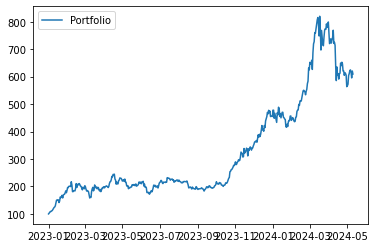

In [25]:
test.evolution(weights).plot()

In [26]:
test.portfolio(weights).std()*np.sqrt(252)

Portfolio    0.524978
dtype: float64

In [27]:
tet=pd.DataFrame(ptf)
tet.iloc[1:].pct_change().std()*np.sqrt(252)

0    0.614343
dtype: float64

<AxesSubplot:>

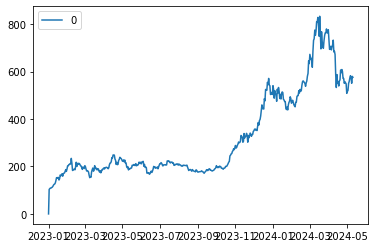

In [28]:
(tet*100).plot()

<AxesSubplot:>

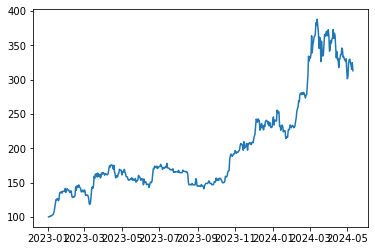

In [29]:
((1+returns['BTCUSDT']).cumprod()*100).plot()

In [30]:
var,cvar=test.historical_var(weights)
var,cvar

(-0.05456307163964853, -0.07020145330114058)

In [31]:
var,cvar=test.parametric_var(weights)
var,cvar

(-0.054450283590696286, -0.06979020889363656)

In [32]:
perf=performance(test.multivariate_distribution(),weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05067473053565369, -0.06438700994182184)

In [33]:
cop=test.gaussian_copula()
perf=performance(cop,weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.04951506372690491, -0.0636156726352993)

In [34]:
t_copula=test.t_copula()
perf=performance(t_copula,weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0504865169498106, -0.06537200024594843)

In [35]:
spot=data.iloc[-1]
monte_carlo=test.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1],weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05470777387629261, -0.06869504610909667)

In [36]:
var_data=rolling_var(returns,weights,window=30,Q=1).dropna()
var_data

,Historical,Parametric,Multivariate,Portfolio
2023-01-31,-0.062141,-0.083872,-0.062088,0.044463
2023-02-01,-0.062141,-0.085469,-0.063930,0.060948
2023-02-02,-0.062141,-0.086050,-0.066239,-0.002893
2023-02-03,-0.062141,-0.086046,-0.065578,0.024529
2023-02-04,-0.062141,-0.085935,-0.064267,0.000768
...,...,...,...,...
2024-05-06,-0.099210,-0.096599,-0.101132,0.003605
2024-05-07,-0.099210,-0.096368,-0.097870,-0.012373
2024-05-08,-0.099210,-0.095491,-0.100898,-0.034852
2024-05-09,-0.099210,-0.094630,-0.097636,0.042266


<AxesSubplot:>

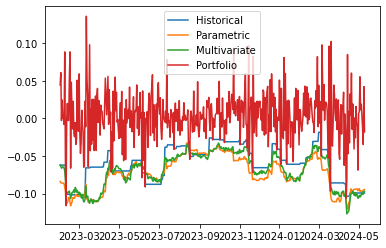

In [37]:
var_data.plot()

In [38]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.040773,0.01073,0.017167
Kupiec Stat,0.889085,21.956104,14.0186
P-value,0.345725,0.000003,0.000181


In [39]:
eigval,eigvec,portfolio_components=test.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.58783548, 0.15058187, 0.10203522, 0.08199115, 0.07755628])

In [40]:
#portfolio_components

<AxesSubplot:>

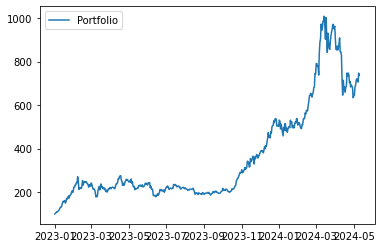

In [41]:
test.evolution(portfolio_components["PC1"]).plot()

In [42]:
#((1+get_close(['^STOXX50E'],"2022-01-01").pct_change()).cumprod()*100).plot()